# Programming Assignment 4
**Pooya Kabiri - 96521434**

Importing prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Plotting cell

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# Changing Phase and Magnitude

Implementing some helper functions:

**`compute_phase_magnitude(image)`** : This method get an image as input and returns the phase and magnitude of the image 

**`compute_ifft(phase, magnitude)`** : This method get magnitude and phase as input, computes the complex spectrum of the image and returns the image by using inverse fast fourier transform.

In [3]:
def compute_phase_magnitude(image):
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    phase_spectrum = np.angle(dft_shift)
    magnitude_spectrum = np.abs(dft_shift)
        
    return phase_spectrum, magnitude_spectrum

def compute_ifft(phase, magnitude):
    
    complex_spectrum = magnitude * np.exp(phase * 1j)
    shift = np.fft.ifftshift(complex_spectrum)
    ifft = np.fft.ifft2(shift)
    
    return np.abs(ifft)

Implementing functions for changing phases and amplitudes of images.

In [4]:
def draw_phase_amplitude(image):
    '''
    Returns the phase image and the amplitude image from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        tuple of numpy.ndarray: The tuple of the phase image and the amplitude image.   
    '''
    
    phase, amp = compute_phase_magnitude(image)
    
    ### Used np.log so that the amplitude can be shown like a image and values don't be too large or too small
    amp = np.log(amp)
    
    return phase, amp

def change_phase_domain(image1, image2):
    '''
    Substitutes the phase of image1 by the phase of image2 and returns two new images.
    
    Parameters:
        image1 (numpy.ndarray): The input image1.
        image2 (numpy.ndarray): The input image2.
    
    Returns:
        tuple of numpy.ndarray: The tuple of result images.   
    '''
    
    phase_1, mag_1 = compute_phase_magnitude(image1)
    phase_2, mag_2 = compute_phase_magnitude(image2)
    
    img1 = compute_ifft(phase_1, mag_2)
    img2 = compute_ifft(phase_2, mag_1)
    
    return img1, img2

Test of implementation:

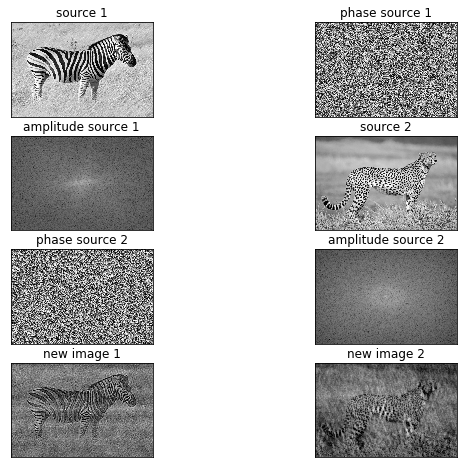

In [5]:
image_list = []
image1 = cv2.imread(os.path.join('images', '1.jpg'), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join('images', '2.jpg'), cv2.IMREAD_GRAYSCALE)

image_list.append([image1, 'source 1', 'img'])

phase1, amp1 = draw_phase_amplitude(image1)
image_list.append([phase1, 'phase source 1', 'img'])
image_list.append([amp1, 'amplitude source 1', 'img'])

image_list.append([image2, 'source 2', 'img'])

phase2, amp2 = draw_phase_amplitude(image2)
image_list.append([phase2, 'phase source 2', 'img'])
image_list.append([amp2, 'amplitude source 2', 'img'])

res1, res2 = change_phase_domain(image1, image2)
image_list.append([res1, 'new image 1', 'img'])
image_list.append([res2, 'new image 2', 'img'])

plotter(image_list, 4, 2, True, 10, 8, 'Q3')

#### Result:
**Changing image phase and magnitude:** As can be seen above, the image of zebra hasn't changes that much even its phase is swaped with the cheetah image.
**So,** we can infer from above that most useful information and data of an image is encapsulated in the image **phase** and the data is more stored in **phase** rather than **magnitude**


# Removing Periodic Noise

**`denoise_image(image)`**: This method gets image with periodic noise as an input, blocks the noisy areas of frequency spectrum magnitude and uses inverse fourier transform to recompute the image, and returns the denoised image.

In [6]:
def denoise_image(image):
    '''
    Denoises the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result denoised image.   
    '''
    
    denoised = image.copy()
    
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    ### These indices are calculated using photoshop and hard-coded for this problem.
    dft_shift[:,:190] = 0.000001
    dft_shift[:,320:] = 0.000001

    dft_shift[:190,:] = 0.000001
    dft_shift[320:,:] = 0.000001
    
    idft_shift = np.fft.ifftshift(dft_shift)
    idft = np.fft.ifft2(idft_shift)
    
    denoised = np.abs(idft)
    return denoised

Test of implementation:

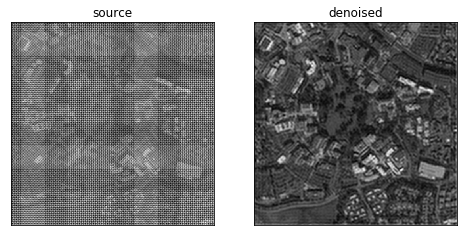

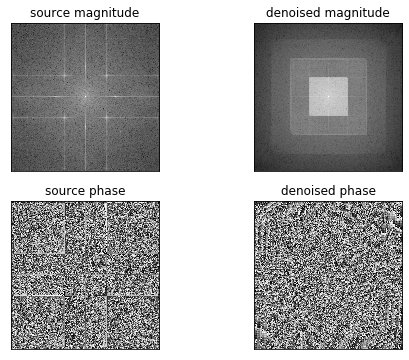

In [7]:
image_list = []
image = cv2.imread(os.path.join('images', '3.jpg'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])

denoised = denoise_image(image)
image_list.append([denoised, 'denoised', 'img'])
plotter(image_list, 1, 2, True, 8, 6, 'Q4')

fft_list = []
phase1, mag1 = draw_phase_amplitude(image)
phase2, mag2 = draw_phase_amplitude(denoised)

fft_list.append([mag1, 'source magnitude', 'img'])
fft_list.append([mag2, 'denoised magnitude', 'img'])
fft_list.append([phase1, 'source phase', 'img'])
fft_list.append([phase2, 'denoised phase', 'img'])

plotter(fft_list, 2, 2, True, 8, 6, '')

**As we can see**, The periodic noise is removed.
If we look at the magnitudes before and after the operation, we can see that all noisy parts of the magnitude is blocked, So the periodic noise is removed.

# Image Sharpening

Implementing some helper functions:

**`gaussian(x, y, std)`** : This method get coordinates and standard deviation as input and returns the gaussian value for the parameteres.

**`gaussian_filter(shape, std)`** : Gets a shape and standard deviation as input and creates a gaussian kernel of desired shape using the method above.

In [8]:
# Copied from HW3 with slight modifications

def gaussian(x, y, std):
    return np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(std)))


def gaussian_filter(shape, std):
    '''
    Creates the Guassian kernel with given size and std.
    
    Parameters:
        size (int): The size of the kernel. It must be odd.
        std (float): The standard deviation of the kernel.
    
    Returns:
        numpy.ndarray: The Guassina kernel.
    '''
    
    kernel = np.zeros((shape[0],shape[1]), np.float)
    
    gap_x = np.floor(shape[0] / 2)
    gap_y = np.floor(shape[1] / 2)
    
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            x = i - gap_x
            y = j - gap_y
            kernel[i, j] = gaussian(x, y, std)

    return kernel

Implement this function for enhancing input image and return result image.

In [9]:
def enhance_image(image):
    '''
    Enhances the input image by applying a filter in the frequency domain.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result enhanced image.   
    '''

    ###  Inverting the gaussian kernel to become a high pass filter.
    inv_kernel = 1 - gaussian_filter(image.shape, 15)
    
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    edges = dft_shift * inv_kernel
        
    idft_shift = np.fft.ifftshift(edges)
    idft = np.fft.ifft2(idft_shift)
    
    enhanced = np.abs(idft) + image
    return enhanced

Test of implementation:

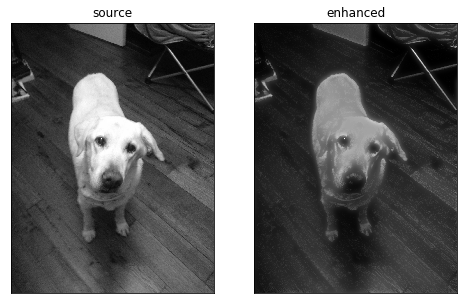

In [10]:
image_list = []
image = cv2.imread(os.path.join('images', '4.jpg'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source','img'])
image_list.append([enhance_image(image), 'enhanced', 'img'])
plotter(image_list, 1, 2, True, 8, 6, 'Q5')

**As we can see**, The image edges are a lot more visible and the image is enhanced significantly.